In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import os
import numpy as np
from wordcloud import WordCloud

In [4]:
def filter_data(hdf5_file):
    valid_images = []
    valid_labels = []

    # Chunk size is the number of images we'll load at a time
    chunk_size = 500

    # Get references to the datasets
    image_dataset = hdf5_file['data']
    label_dataset = hdf5_file['labels/resnet/rc_64']

    # Go through the datasets in chunks
    for i in range(0, len(image_dataset), chunk_size):
        # Load one chunk
        image_chunk = image_dataset[i:i + chunk_size]
        label_chunk = label_dataset[i:i + chunk_size]

        # Determine the size of the smaller chunk
        min_chunk_size = min(len(image_chunk), len(label_chunk))

        # Truncate chunks to the size of the smaller one
        image_chunk = image_chunk[:min_chunk_size]
        label_chunk = label_chunk[:min_chunk_size]

        # Identify valid labels in this chunk
        valid_mask = label_chunk != -1  # Modify this condition to match your actual criteria for invalid labels

        # Select only valid images and labels and add them to our lists
        valid_images.extend(image_chunk[valid_mask])
        valid_labels.extend(label_chunk[valid_mask])

    return np.array(valid_images), np.array(valid_labels)

# Usage:
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
valid_images, valid_labels = filter_data(hdf5_file)

# Load the data
images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_128'][:])
real_logos = valid_images
labels = valid_labels

# Normalize pixel values to the range [0, 1]
real_logos = real_logos.astype('float32') / 255.0
# Split the data into training and validation sets
train_data, val_data = train_test_split(real_logos, test_size=0.2, random_state=42)
labels_train, labels_val = train_test_split(labels, test_size=0.2, random_state=42)

train_data_tenth = train_data[:int(len(train_data)/10)]


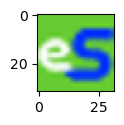

In [5]:
# Investigate the icon data using matplotlib
fig = plt.figure(figsize=(1, 1))
plt.imshow(np.transpose(images[20], (1, 2, 0)))

In [7]:
# Initiate a GAN model using tensorflow & keras
# Generator
latent_dim = 100
num_classes = 64
generator = keras.Sequential()
generator.add(layers.Dense(256, activation="relu", input_dim=latent_dim + num_classes))
generator.add(layers.Dense(512, activation="relu"))
generator.add(layers.Dense(1024, activation="relu"))
generator.add(layers.Dense(2056, activation="relu"))
generator.add(layers.Dense(32*32*3, activation="relu"))
generator.add(layers.Reshape((32, 32, 3)))

# Discriminator
discriminator = keras.Sequential()
discriminator.add(layers.Flatten(input_shape=(32, 32, 3)))
discriminator.add(layers.Dense(2056, activation='relu'))
discriminator.add(layers.Dense(1024, activation='relu'))
discriminator.add(layers.Dense(512, activation='relu'))
discriminator.add(layers.Dense(256, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

# Discriminator Network
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Create the GAN model
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim + num_classes,))
# Pass the input through the generator model
generated_images = generator(gan_input)
# Pass the generated images through the discriminator model
gan_output = discriminator(generated_images)
gan = keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [8]:
# Create a function to generate a batch of random labels
def generate_labels(batch_size):
    # Generate random labels for the given batch size
    labels = np.random.randint(0, num_classes, batch_size)
    return tf.one_hot(labels, num_classes)

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

# Create a function to generate a batch of fake images
def generate_fake_samples(generator, n_samples, noise_dim):
    noise = generate_noise(n_samples, noise_dim)
    fake_logos = generator.predict(noise)
    return fake_logos

# Train the GAN model
def train_gan(generator, discriminator, gan, train_data, labels_train, n_epochs, n_batches, batch_size, latent_dim):
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            start_index = batch * batch_size
            end_index = min((batch + 1) * batch_size, train_data.shape[0])
            batch_indices = np.arange(start_index, end_index)
            real_batch = train_data[batch_indices]
            real_batch = np.transpose(real_batch, (0, 2, 3, 1))
            
            # Use tf.one_hot to one-hot encode the labels
            label_batch = tf.one_hot(labels_train[batch_indices], num_classes)
            noise = generate_noise(real_batch.shape[0], latent_dim)
            
            # Generate conditional labels for the fake images
            fake_labels = generate_labels(real_batch.shape[0])
            
            # Concatenate noise and fake_labels for the generator input to generate fake samples
            generator_input = tf.concat([noise, fake_labels], axis=1)
            
            fake_batch = generator.predict(generator_input)

            X = np.concatenate([real_batch, fake_batch])
            y = np.concatenate([np.ones((real_batch.shape[0], 1)), np.zeros((real_batch.shape[0], 1))])
            discriminator_loss = discriminator.train_on_batch(X, y)

            # Train the Generator
            noise = generate_noise(real_batch.shape[0], latent_dim)
            y = np.ones((real_batch.shape[0], 1))
            
            # Concatenate noise and label_batch (real labels) for the generator input for generator training
            generator_input = tf.concat([noise, label_batch], axis=1)
            
            generator_loss = gan.train_on_batch(generator_input, y)

        #Print the loss at the end of each epoch
        print(f'Epoch {epoch + 1}/{n_epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}')

            

In [9]:
n_epochs = 2
batch_size = 2048
n_batches = int(np.ceil(train_data.shape[0] / batch_size))

train_gan(generator, discriminator, gan, train_data, labels_train, n_epochs, n_batches, batch_size, latent_dim)

63/63 [==============================] - 1s 8ms/step
Epoch 1/2 - Discriminator Loss: 0.0039932443760335445 - Generator Loss: 11.472341537475586
63/63 [==============================] - 0s 6ms/step
Epoch 2/2 - Discriminator Loss: 0.13316771388053894 - Generator Loss: 9.2269926071167


In [25]:
import matplotlib.pyplot as plt

# Define the number of images to generate
num_images_to_generate = 200000  # You can change this value

# Generate random noise
noise = generate_noise(num_images_to_generate, latent_dim)

6250/6250 [==============================] - 51s 8ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0

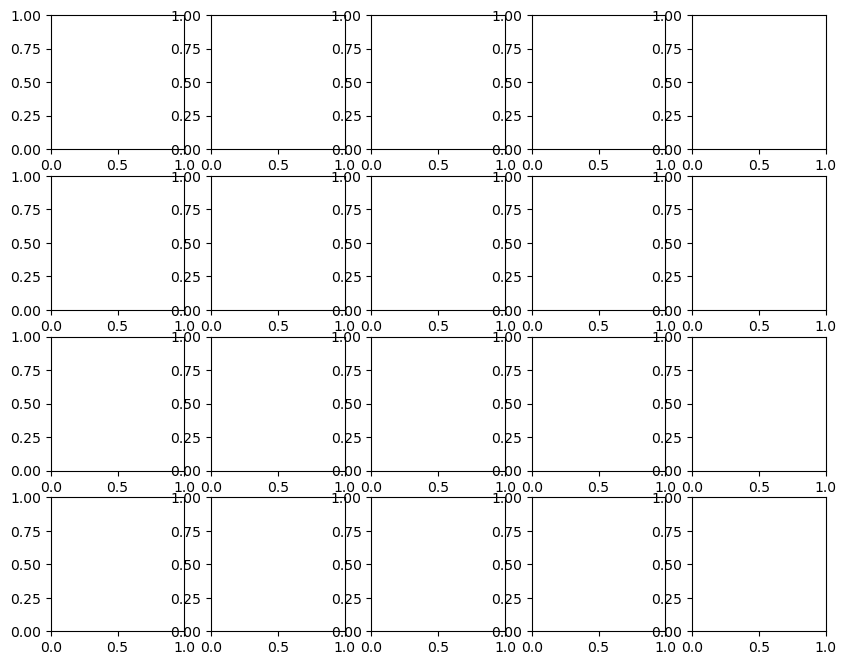

In [26]:
import matplotlib.pyplot as plt

# Generate random labels
random_labels = np.random.randint(0, num_classes, num_images_to_generate)

# Use tf.one_hot to one-hot encode the labels
random_labels = tf.one_hot(random_labels, num_classes)

# Concatenate noise and labels for the generator input
generator_input = tf.concat([noise, random_labels], axis=1)

# Generate fake images
fake_images = generator.predict(generator_input)

# Get discriminator predictions for the fake images
predictions = discriminator.predict(fake_images)

# Get the indices of images that the discriminator thinks are real
real_indices = np.where(predictions > 0.5)[0]

# Filter out the "real" images and their predictions
real_fake_images = fake_images[real_indices]
real_fake_predictions = predictions[real_indices]

# Sort predictions in descending order and get the indices of top 20
top_indices = real_fake_predictions.argsort()[-20:][::-1]

# Select the top 20 images
filtered_images = real_fake_images[top_indices]
filtered_predictions = real_fake_predictions[top_indices]

# Visualize the filtered images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    image = (filtered_images[i] + 1) / 2.0
    ax.imshow(image)
    ax.set_title(f"Prediction: {filtered_predictions[i][0]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

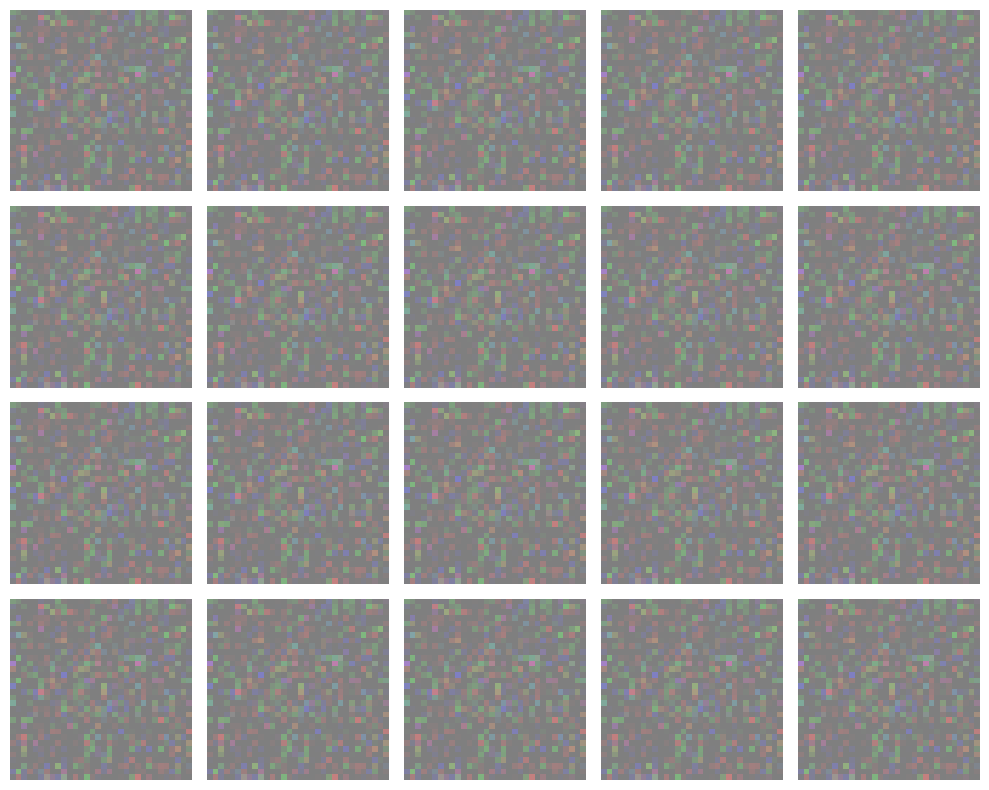

In [28]:
# Visualize the filtered images and their predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()